# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                 
Sample_059  Q9P2E7;Q9P2E7-2                                   15.694
Sample_010  F5GZS6;J3KPF3;P08195;P08195-2;P08195-3;P08195-4   16.678
Sample_079  A0A075B6I0                                        17.596
Sample_095  F5GY55;Q16531                                     15.052
Sample_038  Q8NI22                                            15.407
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups                            
Sample_048  P78310;P78310-2;P78310-5;P78310-6;P78310-7   14.974
Sample_019  K7EKL3;K7EQ05;P28799;P28799-2;P28799-3       14.141
Sample_131  P08582                                       13.334
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.111
            A0A075B6Q5                 11.954
            A0A075B6R2                 11.571
            A0A075B6S5                 13.645
            A0A087WSY4                 11.803
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.774
            Q9UI40;Q9UI40-2            12.435
            Q9UIW2                     12.348
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.479
            Q9UP79                     12.446
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.083,15.050,16.842,19.863,16.063,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.821,19.067,...,15.528,15.576,14.576,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.821,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.483,17.705,17.039,15.750,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.186,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.392,15.345,17.084,18.708,14.249,19.433,12.325,11.029
Sample_207,15.739,16.877,15.469,16.898,14.512,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.111,...,16.012,15.178,13.030,15.050,16.842,19.863,12.503,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,14.407,19.067,16.188,...,15.528,15.576,14.101,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.177,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.175,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.912,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.761,15.345,17.084,18.708,14.249,19.433,12.850,13.678
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 362.48it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.37it/s]

100%|██████████| 3/3 [00:00<00:00,  4.02it/s]

100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.74it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.67it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.38it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.95it/s]

100%|██████████| 5/5 [00:01<00:00,  2.61it/s]

100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.12it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.65it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.05it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.86it/s]

100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

100%|██████████| 6/6 [00:01<00:00,  3.93it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.06it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.61it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.03it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.99it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.81it/s]

100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

100%|██████████| 7/7 [00:02<00:00,  3.06it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.93it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.69it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.57it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.82it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.88it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.99it/s]

100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.46it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.95it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.35it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.03it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.93it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.80it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.81it/s]

100%|██████████| 9/9 [00:02<00:00,  2.82it/s]

100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.07it/s]

 30%|███       | 3/10 [00:00<00:01,  3.66it/s]

 40%|████      | 4/10 [00:01<00:01,  3.23it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.98it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.81it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.91it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.92it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.92it/s]

100%|██████████| 10/10 [00:03<00:00,  3.00it/s]

100%|██████████| 10/10 [00:03<00:00,  3.08it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.29it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.54it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.66it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.26it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.60it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.44it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.72it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.09it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.34it/s]

100%|██████████| 11/11 [00:02<00:00,  4.59it/s]

100%|██████████| 11/11 [00:02<00:00,  4.36it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.94it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.79it/s]

 33%|███▎      | 4/12 [00:00<00:02,  4.00it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.75it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.26it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.13it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.23it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.30it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.31it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.23it/s]

100%|██████████| 12/12 [00:03<00:00,  3.14it/s]

100%|██████████| 12/12 [00:03<00:00,  3.45it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.79it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.58it/s]

 31%|███       | 4/13 [00:00<00:02,  4.11it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.34it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.33it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.15it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.19it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.20it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.11it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.12it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.33it/s]

100%|██████████| 13/13 [00:03<00:00,  3.11it/s]

100%|██████████| 13/13 [00:03<00:00,  3.37it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.47it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.97it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.56it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.84it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.92it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.57it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.44it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.46it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.50it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.35it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.17it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.11it/s]

100%|██████████| 14/14 [00:03<00:00,  3.12it/s]

100%|██████████| 14/14 [00:03<00:00,  3.55it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.10it/s]

 20%|██        | 3/15 [00:00<00:02,  5.92it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.79it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.86it/s]

 40%|████      | 6/15 [00:01<00:02,  3.81it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.82it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.70it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.90it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.01it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.90it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.71it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.70it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.66it/s]

100%|██████████| 15/15 [00:03<00:00,  3.68it/s]

100%|██████████| 15/15 [00:03<00:00,  3.97it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.003      0.062 0.023          0.685 0.387       0.103   
2             0.007 0.006      0.080 0.034          0.711 0.083       0.608   
3             0.005 0.004      0.072 0.026          0.698 0.095       0.600   
4             0.004 0.000      0.051 0.014          0.706 0.085       0.667   
5             0.006 0.005      0.058 0.021          0.707 0.082       0.678   
6             0.005 0.004      0.068 0.027          0.707 0.087       0.678   
7             0.004 0.003      0.052 0.015          0.799 0.083       0.743   
8             0.006 0.004      0.074 0.033          0.806 0.080       0.822   
9             0.005 0.004      0.064 0.022          0.807 0.082       0.818   
10            0.004 0.002      0.047 0.008          0.796 0.079       0.817   
11            0.003 0.001      0.035 0.008          0.795 0.077       0.838   
12            0.004 0.002      0.047 0.011          0.793 0.074       0.827   
13            0.004 0.001      0.046 0.012          0.794 0.075       0.824   
14            0.005 0.003      0.049 0.007          0.803 0.090       0.812   
15            0.004 0.000      0.048 0.005          0.799 0.091       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.171 0.130                  0.542 0.040        0.849   
2          0.102   0.649 0.074                  0.712 0.054        0.782   
3          0.108   0.638 0.079                  0.702 0.058        0.775   
4          0.116   0.678 0.076                  0.729 0.055        0.782   
5          0.107   0.687 0.073                  0.735 0.057        0.801   
6          0.106   0.687 0.074                  0.734 0.058        0.799   
7          0.100   0.766 0.075                  0.802 0.059        0.854   
8          0.094   0.809 0.063                  0.836 0.054        0.906   
9          0.097   0.808 0.063                  0.836 0.054        0.905   
10         0.097   0.803 0.065                  0.830 0.057        0.902   
11         0.093   0.812 0.060                  0.838 0.053        0.906   
12         0.093   0.805 0.059                  0.833 0.052        0.906   
13         0.098   0.804 0.057                  0.832 0.050        0.905   
14         0.088   0.802 0.061                  0.830 0.053        0.910   
15         0.090   0.799 0.061                  0.827 0.053        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.808 0.083        210.000 0.000  
2          0.062                  0.752 0.078        210.000 0.000  
3          0.062                  0.731 0.081        210.000 0.000  
4          0.062                  0.727 0.089        210.000 0.000  
5          0.059                  0.755 0.081        210.000 0.000  
6          0.060                  0.754 0.081        210.000 0.000  
7          0.060                  0.819 0.082        210.000 0.000  
8          0.044                  0.883 0.055        210.000 0.000  
9          0.044                  0.882 0.056        210.000 0.000  
10         0.045                  0.880 0.055        210.000 0.000  
11         0.045                  0.893 0.046        210.000 0.000  
12         0.047                  0.894 0.049        210.000 0.000  
13         0.047                  0.892 0.049        210.000 0.000  
14         0.047                  0.901 0.048        210.000 0.000  
15         0.047                  0.898 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 487.26it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.90it/s]

100%|██████████| 3/3 [00:00<00:00,  4.48it/s]

100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.02it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.21it/s]

100%|██████████| 4/4 [00:01<00:00,  3.62it/s]

100%|██████████| 4/4 [00:01<00:00,  3.95it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.97it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.10it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.03it/s]

100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

100%|██████████| 5/5 [00:01<00:00,  4.37it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.06it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.08it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.40it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  5.08it/s]

100%|██████████| 6/6 [00:01<00:00,  4.87it/s]

100%|██████████| 6/6 [00:01<00:00,  5.30it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.26it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.32it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.72it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.47it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.14it/s]

100%|██████████| 7/7 [00:02<00:00,  3.06it/s]

100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.37it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.62it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.42it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.98it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.78it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.57it/s]

100%|██████████| 8/8 [00:02<00:00,  3.42it/s]

100%|██████████| 8/8 [00:02<00:00,  3.85it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.54it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.86it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.41it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  6.07it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  5.87it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  5.85it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.81it/s]

100%|██████████| 9/9 [00:01<00:00,  5.75it/s]

100%|██████████| 9/9 [00:01<00:00,  6.07it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.18it/s]

 30%|███       | 3/10 [00:00<00:01,  6.28it/s]

 40%|████      | 4/10 [00:00<00:01,  5.47it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.03it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.92it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.57it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.62it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.64it/s]

100%|██████████| 10/10 [00:02<00:00,  4.64it/s]

100%|██████████| 10/10 [00:02<00:00,  4.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.31it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.15it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.55it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.22it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.00it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.92it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.78it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.76it/s]

100%|██████████| 11/11 [00:01<00:00,  5.69it/s]

100%|██████████| 11/11 [00:01<00:00,  6.16it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.21it/s]

 33%|███▎      | 4/12 [00:00<00:01,  7.05it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.54it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.23it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  6.01it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.87it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.78it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.73it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  5.69it/s]

100%|██████████| 12/12 [00:01<00:00,  5.69it/s]

100%|██████████| 12/12 [00:01<00:00,  6.10it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 11.19it/s]

 31%|███       | 4/13 [00:00<00:01,  7.15it/s]

 38%|███▊      | 5/13 [00:00<00:01,  6.71it/s]

 46%|████▌     | 6/13 [00:00<00:01,  6.32it/s]

 54%|█████▍    | 7/13 [00:01<00:00,  6.07it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.91it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.80it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.72it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.74it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.73it/s]

100%|██████████| 13/13 [00:02<00:00,  5.61it/s]

100%|██████████| 13/13 [00:02<00:00,  6.09it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.40it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.12it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.59it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.29it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.05it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.93it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.82it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.78it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.75it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.72it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.77it/s]

100%|██████████| 14/14 [00:02<00:00,  5.72it/s]

100%|██████████| 14/14 [00:02<00:00,  6.09it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.33it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.21it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.68it/s]

 40%|████      | 6/15 [00:00<00:01,  6.33it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.11it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.95it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.88it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.87it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.78it/s]

 80%|████████  | 12/15 [00:01<00:00,  5.75it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.79it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.80it/s]

100%|██████████| 15/15 [00:02<00:00,  5.80it/s]

100%|██████████| 15/15 [00:02<00:00,  6.12it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.032 0.008          0.000 0.000       0.000   
2             0.004 0.003      0.049 0.022          0.617 0.119       0.495   
3             0.003 0.001      0.046 0.016          0.762 0.092       0.675   
4             0.004 0.003      0.043 0.015          0.748 0.085       0.715   
5             0.002 0.000      0.029 0.005          0.748 0.085       0.713   
6             0.003 0.001      0.031 0.007          0.746 0.081       0.718   
7             0.003 0.001      0.040 0.008          0.757 0.087       0.736   
8             0.003 0.001      0.030 0.007          0.753 0.088       0.733   
9             0.002 0.000      0.027 0.001          0.769 0.090       0.727   
10            0.002 0.000      0.027 0.000          0.800 0.088       0.771   
11            0.002 0.000      0.027 0.001          0.794 0.082       0.768   
12            0.002 0.000      0.027 0.000          0.792 0.080       0.769   
13            0.002 0.000      0.027 0.000          0.797 0.081       0.781   
14            0.002 0.000      0.027 0.000          0.800 0.080       0.773   
15            0.002 0.000      0.027 0.000          0.811 0.083       0.773   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.860   
2          0.117   0.542 0.102                  0.633 0.071        0.730   
3          0.124   0.710 0.093                  0.760 0.070        0.862   
4          0.119   0.727 0.088                  0.769 0.070        0.864   
5          0.120   0.725 0.088                  0.769 0.070        0.862   
6          0.116   0.727 0.083                  0.769 0.066        0.859   
7          0.120   0.742 0.087                  0.781 0.071        0.869   
8          0.119   0.738 0.085                  0.778 0.070        0.866   
9          0.118   0.743 0.087                  0.783 0.071        0.869   
10         0.119   0.780 0.083                  0.814 0.068        0.903   
11         0.111   0.776 0.075                  0.810 0.062        0.904   
12         0.109   0.775 0.073                  0.809 0.061        0.903   
13         0.112   0.784 0.079                  0.817 0.065        0.903   
14         0.113   0.781 0.077                  0.815 0.063        0.905   
15         0.101   0.787 0.068                  0.819 0.056        0.906   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.829 0.085        210.000 0.000  
2          0.074                  0.666 0.096        210.000 0.000  
3          0.059                  0.835 0.072        210.000 0.000  
4          0.057                  0.841 0.068        210.000 0.000  
5          0.057                  0.839 0.069        210.000 0.000  
6          0.057                  0.838 0.069        210.000 0.000  
7          0.054                  0.840 0.074        210.000 0.000  
8          0.054                  0.840 0.072        210.000 0.000  
9          0.057                  0.843 0.077        210.000 0.000  
10         0.049                  0.881 0.062        210.000 0.000  
11         0.047                  0.883 0.058        210.000 0.000  
12         0.047                  0.880 0.060        210.000 0.000  
13         0.048                  0.882 0.060        210.000 0.000  
14         0.048                  0.887 0.058        210.000 0.000  
15         0.047                  0.887 0.057 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1340.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 55.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 42.67it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 38.20it/s]

100%|██████████| 4/4 [00:00<00:00, 37.98it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 35.90it/s]

100%|██████████| 5/5 [00:00<00:00, 32.96it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 36.09it/s]

100%|██████████| 6/6 [00:00<00:00, 32.19it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 36.85it/s]

100%|██████████| 7/7 [00:00<00:00, 31.20it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 38.08it/s]

100%|██████████| 8/8 [00:00<00:00, 29.90it/s]

100%|██████████| 8/8 [00:00<00:00, 30.83it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 38.14it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 31.30it/s]

100%|██████████| 9/9 [00:00<00:00, 31.22it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 36.81it/s]

 80%|████████  | 8/10 [00:00<00:00, 30.38it/s]

100%|██████████| 10/10 [00:00<00:00, 30.21it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 33.20it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 29.66it/s]

100%|██████████| 11/11 [00:00<00:00, 28.34it/s]

100%|██████████| 11/11 [00:00<00:00, 28.99it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 36.48it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 30.24it/s]

100%|██████████| 12/12 [00:00<00:00, 29.33it/s]

100%|██████████| 12/12 [00:00<00:00, 30.03it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 35.91it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 30.08it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 28.65it/s]

100%|██████████| 13/13 [00:00<00:00, 29.09it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 38.16it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 32.10it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 30.52it/s]

100%|██████████| 14/14 [00:00<00:00, 31.03it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 37.37it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 31.92it/s]

 80%|████████  | 12/15 [00:00<00:00, 30.59it/s]

100%|██████████| 15/15 [00:00<00:00, 30.60it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.027 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.027 0.000          0.657 0.110       0.485   
3             0.002 0.000      0.027 0.000          0.633 0.113       0.479   
4             0.002 0.000      0.027 0.000          0.631 0.110       0.484   
5             0.002 0.000      0.027 0.000          0.608 0.114       0.465   
6             0.002 0.000      0.027 0.000          0.656 0.094       0.622   
7             0.002 0.000      0.027 0.000          0.655 0.108       0.608   
8             0.002 0.000      0.027 0.001          0.636 0.108       0.596   
9             0.002 0.000      0.027 0.000          0.633 0.109       0.597   
10            0.002 0.000      0.027 0.000          0.638 0.083       0.619   
11            0.002 0.000      0.027 0.000          0.637 0.081       0.618   
12            0.002 0.000      0.027 0.000          0.627 0.086       0.610   
13            0.002 0.000      0.027 0.000          0.627 0.085       0.605   
14            0.002 0.000      0.027 0.000          0.618 0.085       0.602   
15            0.002 0.000      0.027 0.001          0.616 0.084       0.603   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.751   
2          0.114   0.552 0.101                  0.649 0.068        0.725   
3          0.120   0.539 0.104                  0.637 0.070        0.723   
4          0.121   0.541 0.103                  0.638 0.067        0.719   
5          0.125   0.521 0.111                  0.624 0.070        0.710   
6          0.113   0.632 0.082                  0.690 0.065        0.766   
7          0.114   0.625 0.090                  0.684 0.072        0.765   
8          0.121   0.610 0.096                  0.672 0.074        0.761   
9          0.126   0.608 0.100                  0.671 0.076        0.758   
10         0.135   0.622 0.098                  0.682 0.072        0.776   
11         0.129   0.622 0.094                  0.681 0.069        0.773   
12         0.130   0.613 0.098                  0.674 0.070        0.778   
13         0.131   0.610 0.096                  0.672 0.071        0.778   
14         0.136   0.604 0.100                  0.667 0.073        0.776   
15         0.135   0.604 0.099                  0.666 0.073        0.771   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.686 0.084        210.000 0.000  
2          0.076                  0.669 0.092        210.000 0.000  
3          0.076                  0.655 0.091        210.000 0.000  
4          0.075                  0.648 0.090        210.000 0.000  
5          0.075                  0.641 0.091        210.000 0.000  
6          0.065                  0.708 0.083        210.000 0.000  
7          0.070                  0.705 0.091        210.000 0.000  
8          0.070                  0.701 0.087        210.000 0.000  
9          0.069                  0.698 0.087        210.000 0.000  
10         0.065                  0.719 0.087        210.000 0.000  
11         0.067                  0.716 0.090        210.000 0.000  
12         0.067                  0.718 0.090        210.000 0.000  
13         0.067                  0.727 0.087        210.000 0.000  
14         0.066                  0.726 0.086        210.000 0.000  
15         0.068                  0.721 0.088 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,2,2,15
score_time,2,2,8
test_precision,9,15,2
test_recall,11,13,6
test_f1,11,15,6
test_balanced_accuracy,11,15,6
test_roc_auc,14,15,12
test_average_precision,14,15,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.26it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.16it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.67it/s]

 40%|████      | 6/15 [00:00<00:01,  6.35it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.13it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.00it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.90it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.82it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.79it/s]

 80%|████████  | 12/15 [00:01<00:00,  5.80it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.76it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.71it/s]

100%|██████████| 15/15 [00:02<00:00,  5.68it/s]

100%|██████████| 15/15 [00:02<00:00,  6.09it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 38.04it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 32.04it/s]

100%|██████████| 12/12 [00:00<00:00, 30.56it/s]

100%|██████████| 12/12 [00:00<00:00, 31.38it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 12.76it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.70it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.26it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.12it/s]

 50%|█████     | 7/14 [00:00<00:00,  7.03it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.99it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.96it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.80it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.83it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.84it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.81it/s]

100%|██████████| 14/14 [00:01<00:00,  6.83it/s]

100%|██████████| 14/14 [00:01<00:00,  7.11it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


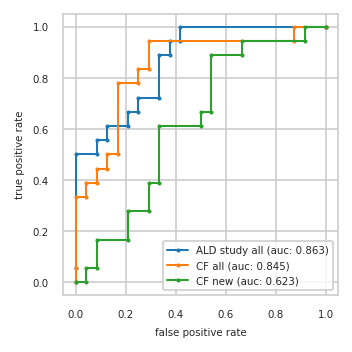

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.500  0.000 0.333  0.042 0.056
3          0.083 0.500  0.042 0.333  0.083 0.056
4          0.083 0.556  0.042 0.389  0.083 0.167
5          0.125 0.556  0.083 0.389  0.208 0.167
6          0.125 0.611  0.083 0.444  0.208 0.278
7          0.208 0.611  0.125 0.444  0.292 0.278
8          0.208 0.667  0.125 0.500  0.292 0.389
9          0.250 0.667  0.167 0.500  0.333 0.389
10         0.250 0.722  0.167 0.778  0.333 0.611
11         0.333 0.722  0.250 0.778  0.500 0.611
12         0.333 0.889  0.250 0.833  0.500 0.667
13         0.375 0.889  0.292 0.833  0.542 0.667
14         0.375 0.944  0.292 0.944  0.542 0.889
15         0.417 0.944  0.875 0.944  0.667 0.889
16         0.417 1.000  0.875 1.000  0.667 0.944
17         1.000 1.000  1.000 1.000  0.917 0.944
18           NaN   NaN    NaN   NaN  0.917 1.000
19           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,F5H265,D6RH31;Q6UXI9;Q6UXI9-3;Q6UXI9-4;Q6UXI9-5;Q6UXI9-6,G3V295;G3V3I1;G3V5Z7;P60900
2,A0A0A0MRJ7;P12259,P08253,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
3,P61981,P02741,P31321
4,P14174,P04075,Q9NUQ9
5,P04075,P14174,Q96GD0
6,Q9Y2T3;Q9Y2T3-3,Q9Y2T3;Q9Y2T3-3,A0A075B7B8
7,P00338;P00338-3,Q14894,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
8,C9JF17;P05090,P63104,Q9Y281;Q9Y281-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


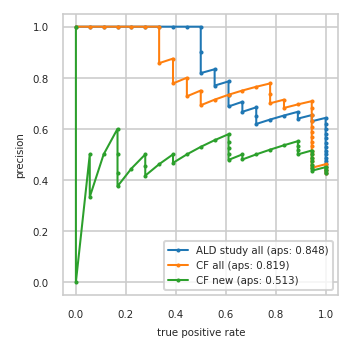

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.447 0.944     0.447 0.944
5          0.486 1.000     0.459 0.944     0.459 0.944
6          0.500 1.000     0.472 0.944     0.472 0.944
7          0.514 1.000     0.486 0.944     0.486 0.944
8          0.529 1.000     0.500 0.944     0.500 0.944
9          0.545 1.000     0.515 0.944     0.515 0.944
10         0.562 1.000     0.531 0.944     0.500 0.889
11         0.581 1.000     0.548 0.944     0.516 0.889
12         0.600 1.000     0.567 0.944     0.533 0.889
13         0.621 1.000     0.586 0.944     0.552 0.889
14         0.643 1.000     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.519 0.778
16         0.654 0.944     0.654 0.944     0.500 0.722
17         0.640 0.889     0.680 0.944     0.480 0.667
18         0.667 0.889     0.708 0.944     0.500 0.667
19         0.652 0.833     0.696 0.889     0.478 0.611
20         0.636 0.778     0.682 0.833     0.500 0.611
21         0.619 0.722     0.714 0.833     0.524 0.611
22         0.650 0.722     0.700 0.778     0.550 0.611
23         0.684 0.722     0.737 0.778     0.579 0.611
24         0.667 0.667     0.778 0.778     0.556 0.556
25         0.706 0.667     0.765 0.722     0.529 0.500
26         0.688 0.611     0.750 0.667     0.500 0.444
27         0.733 0.611     0.733 0.611     0.467 0.389
28         0.786 0.611     0.714 0.556     0.500 0.389
29         0.769 0.556     0.692 0.500     0.462 0.333
30         0.833 0.556     0.750 0.500     0.417 0.278
31         0.818 0.500     0.727 0.444     0.455 0.278
32         0.900 0.500     0.800 0.444     0.500 0.278
33         1.000 0.500     0.778 0.389     0.444 0.222
34         1.000 0.444     0.875 0.389     0.375 0.167
35         1.000 0.389     0.857 0.333     0.429 0.167
36         1.000 0.333     1.000 0.333     0.500 0.167
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


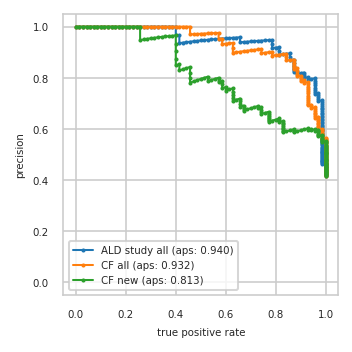

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


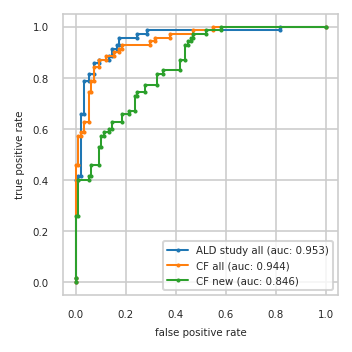

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}